# 正則化（Dropout）

---
## 目的
多層パーセプトロン (Multi Layer Perceptoron; MLP) を用いたMNISTデータセットの認識において，ネットワークの正則化（Dropout）について理解する．

## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gzip

## データセットのダウンロードと読み込みと学習サンプルの削減


まずはじめに，`wget`コマンドを使用して，MNISTデータセットをダウンロードします．

In [9]:
!wget -q https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz
!wget -q https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz
!wget -q https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz
!wget -q https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz

次に，ダウンロードしたファイルからデータを読み込みます．詳細は前回までのプログラムを確認してください．


ここで，学習データを削減します．
今回は500サンプルになるように，先頭から500個の学習データとラベルを取得します．

In [10]:
# load images
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), np.uint8, offset=16)
x_train = x_train.reshape(-1, 784)

with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    x_test = np.frombuffer(f.read(), np.uint8, offset=16)
x_test = x_test.reshape(-1, 784)

with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

# 学習サンプルの削減
x_train = x_train[0:500, :]
y_train = y_train[0:500]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(500, 784) (500,)
(10000, 784) (10000,)


## ネットワークモデルの定義
次に，ニューラルネットワーク（多層パーセプトロン）を定義します．

まずはじめに，ネットワークの定義に必要な関数を定義します．

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x.shape)
    grad[x > 0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    else:
        return np.exp(x) / np.sum(np.exp(x))

次に，上で定義した関数を用いてネットワークを定義します．
ここでは，Dropoutを適用する場合としない場合の2種類の7層の多層パーセプトロンを定義します．

まず，Dropoutを適用しないネットワーク`MLP`を定義します．詳細については前回までの資料を確認してください．


In [12]:
class MLP:

    def __init__(self, input_size, hidden_size, output_size, w_std=0.05):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b2 = np.zeros(hidden_size)
        self.w3 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b3 = np.zeros(hidden_size)
        self.w4 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b4 = np.zeros(hidden_size)
        self.w5 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b5 = np.zeros(hidden_size)
        self.w6 = w_std * np.random.randn(hidden_size, output_size)
        self.b6 = np.zeros(output_size)

        self.act = relu
        self.act_grad = relu_grad

        self.grads = {}

    def forward(self, x, train_mode=False):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = self.act(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.h4 = self.act(self.h3)
        self.h5 = np.dot(self.h4, self.w3) + self.b3
        self.h6 = self.act(self.h5)
        self.h7 = np.dot(self.h6, self.w4) + self.b4
        self.h8 = self.act(self.h7)
        self.h9 = np.dot(self.h8, self.w5) + self.b5
        self.h10 = self.act(self.h9)
        self.h11 = np.dot(self.h10, self.w6) + self.b6
        self.y = softmax(self.h11)
        return self.y

    def backward(self, x, t):
        batch_size = x.shape[0]
        self.grads = {}

        t = np.identity(10)[t]
        dy = (self.y - t) / batch_size
        self.grads['w6'] = np.dot(self.h10.T, dy)
        self.grads['b6'] = np.sum(dy, axis=0)

        d_h10 = np.dot(dy, self.w6.T)
        d_h9 = self.act_grad(self.h9) * d_h10
        self.grads['w5'] = np.dot(self.h8.T, d_h9)
        self.grads['b5'] = np.sum(d_h9, axis=0)

        d_h8 = np.dot(d_h9, self.w5.T)
        d_h7 = self.act_grad(self.h7) * d_h8
        self.grads['w4'] = np.dot(self.h6.T, d_h7)
        self.grads['b4'] = np.sum(d_h7, axis=0)

        d_h6 = np.dot(d_h7, self.w4.T)
        d_h5 = self.act_grad(self.h5) * d_h6
        self.grads['w3'] = np.dot(self.h4.T, d_h5)
        self.grads['b3'] = np.sum(d_h5, axis=0)

        d_h4 = np.dot(d_h5, self.w3.T)
        d_h3 = self.act_grad(self.h3) * d_h4
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)

        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = self.act_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)

    def update_parameters(self, lr=0.1):
        self.w1 -= lr * self.grads['w1']
        self.b1 -= lr * self.grads['b1']
        self.w2 -= lr * self.grads['w2']
        self.b2 -= lr * self.grads['b2']
        self.w3 -= lr * self.grads['w3']
        self.b3 -= lr * self.grads['b3']
        self.w4 -= lr * self.grads['w4']
        self.b4 -= lr * self.grads['b4']
        self.w5 -= lr * self.grads['w5']
        self.b5 -= lr * self.grads['b5']
        self.w6 -= lr * self.grads['w6']
        self.b6 -= lr * self.grads['b6']

次に，Dropoutを適用する場合のネットワーク`MLPDropout`を定義します．


`__init__`関数でネットワークの初期化を行う際に，`dropout_ratio`という変数を定義します．この変数によってdropoutを適用する割合(`0 ~ 1`)を指定します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．
ここでは最終層手前の全結合層後にdropoutを適用します．
まず，Dropoutへ入力されるデータの配列のサイズを`_batch_size`, `_feature_dims`として取得します．
そして，入力データの次元と同じサイズの乱数で初期化された配列を`np.random.rand`で生成し，`dropout_ratio`を閾値として，マスク`dropout_mask`を作成します．
この時，`dropout_mask`の各要素には閾値処理により`[True, False]`が格納されています．
そのマスクを入力データと掛けることで，`False`の部分の値が0となったデータを出力します．

次に，`backward`関数ではパラメータの更新量を計算します．
Dropout部分では，上の`forward`関数を計算する際に保存しておいた`self.dropout_mask`と勾配を掛け合わせることで，Dropoutを考慮した勾配を計算することができます．

In [13]:
class MLPDropout:

    def __init__(self, input_size, hidden_size, output_size, dropout_ratio=0.5, w_std=0.05):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b2 = np.zeros(hidden_size)
        self.w3 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b3 = np.zeros(hidden_size)
        self.w4 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b4 = np.zeros(hidden_size)
        self.w5 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b5 = np.zeros(hidden_size)
        self.w6 = w_std * np.random.randn(hidden_size, output_size)
        self.b6 = np.zeros(output_size)

        self.act = relu
        self.act_grad = relu_grad

        # dropoutのパラメータ
        self.dropout_ratio = dropout_ratio

        self.grads = {}

    def forward(self, x, train_mode=True):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = self.act(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.h4 = self.act(self.h3)
        self.h5 = np.dot(self.h4, self.w3) + self.b3
        self.h6 = self.act(self.h5)
        self.h7 = np.dot(self.h6, self.w4) + self.b4
        self.h8 = self.act(self.h7)

        # dropoutの適用 =============
        if train_mode:
          self.dropout_mask8 = np.random.rand(self.h8.shape[1]) > self.dropout_ratio
          self.h8_d = self.h8 * self.dropout_mask8
        else:
          self.h8_d = self.h8
        # ==========================

        self.h9 = np.dot(self.h8_d, self.w5) + self.b5
        self.h10 = self.act(self.h9)

        # dropoutの適用 =============
        if train_mode:
          self.dropout_mask10 = np.random.rand(self.h10.shape[1]) > self.dropout_ratio
          self.h10_d = self.h10 * self.dropout_mask10
        else:
          self.h10_d = self.h10
        # ==========================

        self.h11 = np.dot(self.h10_d, self.w6) + self.b6
        self.y = softmax(self.h11)
        return self.y

    def backward(self, x, t):
        batch_size = x.shape[0]
        self.grads = {}

        t = np.identity(10)[t]
        dy = (self.y - t) / batch_size
        self.grads['w6'] = np.dot(self.h10.T, dy)
        self.grads['b6'] = np.sum(dy, axis=0)

        d_h10_d = np.dot(dy, self.w6.T)

        # dropout部分の勾配計算 ======
        d_h10 = d_h10_d * self.dropout_mask10
        # ==========================

        d_h9 = self.act_grad(self.h9) * d_h10
        self.grads['w5'] = np.dot(self.h8.T, d_h9)
        self.grads['b5'] = np.sum(d_h9, axis=0)

        d_h8_d = np.dot(d_h9, self.w5.T)

        # dropout部分の勾配計算 ======
        d_h8 = d_h8_d * self.dropout_mask8
        # ==========================

        d_h7 = self.act_grad(self.h7) * d_h8
        self.grads['w4'] = np.dot(self.h6.T, d_h7)
        self.grads['b4'] = np.sum(d_h7, axis=0)

        d_h6 = np.dot(d_h7, self.w4.T)
        d_h5 = self.act_grad(self.h5) * d_h6
        self.grads['w3'] = np.dot(self.h4.T, d_h5)
        self.grads['b3'] = np.sum(d_h5, axis=0)

        d_h4 = np.dot(d_h5, self.w3.T)
        d_h3 = self.act_grad(self.h3) * d_h4
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)

        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = self.act_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)

    def update_parameters(self, lr=0.1):
        self.w1 -= lr * self.grads['w1']
        self.b1 -= lr * self.grads['b1']
        self.w2 -= lr * self.grads['w2']
        self.b2 -= lr * self.grads['b2']
        self.w3 -= lr * self.grads['w3']
        self.b3 -= lr * self.grads['b3']
        self.w4 -= lr * self.grads['w4']
        self.b4 -= lr * self.grads['b4']
        self.w5 -= lr * self.grads['w5']
        self.b5 -= lr * self.grads['b5']
        self.w6 -= lr * self.grads['w6']
        self.b6 -= lr * self.grads['b6']

## 学習
サンプル数を削減したMNISTデータセットと作成したネットワークを用いて，２つのネットワークの学習を行います．

まず，学習およびネットワークに関するパラメータを設定します．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を100とします．

また，中間層と出力層のユニット数を定義します．
ここでは，入力層のユニット数`input_size`を学習データの次元，中間層のユニット数`hidden_size`100`output_size`を10とします．

In [14]:
# 学習途中の精度を確認するための関数
def multiclass_classification_accuracy(pred, true):
    clf_res = np.argmax(pred, axis=1)
    return np.sum(clf_res == true).astype(np.float32)

# 学習中の誤差を確認するための関数
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# 学習パラメータ
num_train_data = x_train.shape[0]
num_test_data = x_test.shape[0]
batch_size = 100
epoch_num = 100
learning_rate = 0.01

# ネットワークのパラメータ
input_size = x_train.shape[1]
hidden_size = 100
output_size = 10

### Dropout無しのモデルの学習

Dropout無しのネットワークモデルを学習します．
上で定義したパラメータを使用して，ネットワーク`MLP`を初期化し，学習を行います．
学習プログラムの詳細については前回までの資料を参照してください．

In [15]:
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

epoch_list = []
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iteration = 0
for epoch in range(1, epoch_num + 1):
    sum_accuracy, sum_loss = 0.0, 0.0
    perm = np.random.permutation(num_train_data)
    for i in range(0, num_train_data, batch_size):
        x_batch = x_train[perm[i:i+batch_size]]
        y_batch = y_train[perm[i:i+batch_size]]

        y = model.forward(x_batch)
        sum_accuracy += multiclass_classification_accuracy(y, y_batch)
        sum_loss += cross_entropy(y, y_batch)

        model.backward(x_batch, y_batch)
        model.update_parameters(lr=learning_rate)
        iteration += 1

    # テストデータに対する認識精度の計算
    test_correct_count = 0
    for i in range(num_test_data):
        input = x_test[i:i+1]
        label = y_test[i:i+1]
        y = model.forward(input)
        test_correct_count += multiclass_classification_accuracy(y, label)

    # 学習途中のlossと精度の保存
    epoch_list.append(epoch)
    train_loss_list.append(sum_loss / num_train_data)
    train_accuracy_list.append(sum_accuracy / num_train_data)
    test_accuracy_list.append(test_correct_count / num_test_data)

    print("epoch: {}, train loss: {}, train accuracy: {}, test accuracy: {}".format(epoch,
                                                               sum_loss / num_train_data,
                                                               sum_accuracy / num_train_data,
                                                               test_correct_count / num_test_data))

epoch: 1, train loss: 0.02184793055229691, train accuracy: 0.21, test accuracy: 0.3352
epoch: 2, train loss: 0.01887534949462821, train accuracy: 0.408, test accuracy: 0.3906
epoch: 3, train loss: 0.01639369785136657, train accuracy: 0.512, test accuracy: 0.4914
epoch: 4, train loss: 0.014674738801710207, train accuracy: 0.554, test accuracy: 0.4293
epoch: 5, train loss: 0.01398818732578818, train accuracy: 0.564, test accuracy: 0.6215
epoch: 6, train loss: 0.00950663487413293, train accuracy: 0.754, test accuracy: 0.6322
epoch: 7, train loss: 0.008440913281029723, train accuracy: 0.716, test accuracy: 0.6765
epoch: 8, train loss: 0.007543549861238768, train accuracy: 0.774, test accuracy: 0.5388
epoch: 9, train loss: 0.007458442727241634, train accuracy: 0.778, test accuracy: 0.6862
epoch: 10, train loss: 0.006505146060826619, train accuracy: 0.8, test accuracy: 0.6426
epoch: 11, train loss: 0.005405559723742231, train accuracy: 0.838, test accuracy: 0.6998
epoch: 12, train loss: 0.00

### Dropoutありのモデルの学習

次にDropoutありのネットワークモデルの学習を行います．
この時，Dropoutの割合`dropout_ratio`を`0.3`に設定します．

テストデータの認識精度を計算する際は，Dropoutの適用を行わないようにするために，
`train_mode=False`と指定することに注意してください．

In [16]:
model_dout = MLPDropout(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_ratio=0.3)

epoch_list_dout = []
train_loss_list_dout = []
train_accuracy_list_dout = []
test_accuracy_list_dout = []

iteration = 0
for epoch in range(1, epoch_num + 1):
    sum_accuracy, sum_loss = 0.0, 0.0
    perm = np.random.permutation(num_train_data)
    for i in range(0, num_train_data, batch_size):
        x_batch = x_train[perm[i:i+batch_size]]
        y_batch = y_train[perm[i:i+batch_size]]

        y = model_dout.forward(x_batch)
        sum_accuracy += multiclass_classification_accuracy(y, y_batch)
        sum_loss += cross_entropy(y, y_batch)

        model_dout.backward(x_batch, y_batch)
        model_dout.update_parameters(lr=learning_rate)
        iteration += 1

    # テストデータに対する認識精度の計算
    test_correct_count = 0
    for i in range(num_test_data):
        input = x_test[i:i+1]
        label = y_test[i:i+1]
        y = model_dout.forward(input, train_mode=False)
        test_correct_count += multiclass_classification_accuracy(y, label)

    # 学習途中のlossと精度の保存
    epoch_list_dout.append(epoch)
    train_loss_list_dout.append(sum_loss / num_train_data)
    train_accuracy_list_dout.append(sum_accuracy / num_train_data)
    test_accuracy_list_dout.append(test_correct_count / num_test_data)

    print("epoch: {}, train loss: {}, train accuracy: {}, test accuracy: {}".format(epoch,
                                                               sum_loss / num_train_data,
                                                               sum_accuracy / num_train_data,
                                                               test_correct_count / num_test_data))

epoch: 1, train loss: 0.02377289334320796, train accuracy: 0.122, test accuracy: 0.2089
epoch: 2, train loss: 0.022519651705025488, train accuracy: 0.186, test accuracy: 0.2579
epoch: 3, train loss: 0.02185250045274716, train accuracy: 0.246, test accuracy: 0.2961
epoch: 4, train loss: 0.021654666551561345, train accuracy: 0.252, test accuracy: 0.3259
epoch: 5, train loss: 0.020540624657779803, train accuracy: 0.346, test accuracy: 0.3293
epoch: 6, train loss: 0.020215552479332075, train accuracy: 0.342, test accuracy: 0.3661
epoch: 7, train loss: 0.01908282649822874, train accuracy: 0.378, test accuracy: 0.3434
epoch: 8, train loss: 0.01779653990974183, train accuracy: 0.43, test accuracy: 0.4373
epoch: 9, train loss: 0.01699725299909201, train accuracy: 0.43, test accuracy: 0.4728
epoch: 10, train loss: 0.01667393129531321, train accuracy: 0.444, test accuracy: 0.5402
epoch: 11, train loss: 0.014939575379671366, train accuracy: 0.516, test accuracy: 0.4976
epoch: 12, train loss: 0.01

## 学習推移のグラフ化

最後に2つのネットワークの学習推移を一つのグラフにまとめてプロットすることで，違いを確認します．


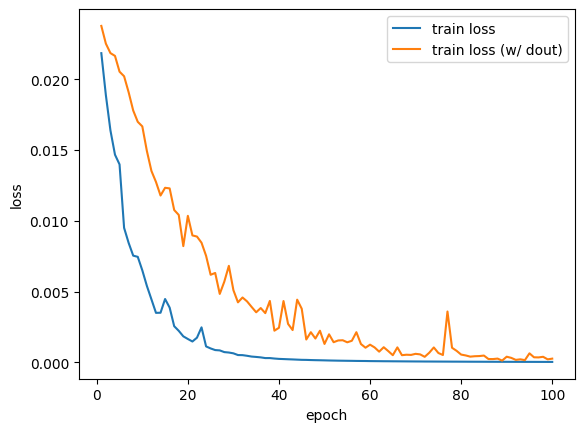

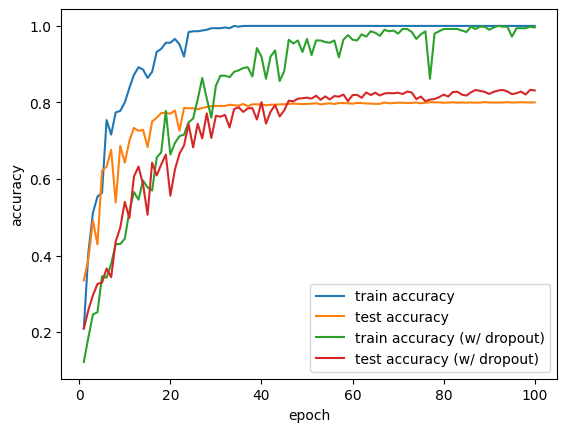

In [17]:
plt.figure()
plt.plot(epoch_list, train_loss_list, label='train loss')
plt.plot(epoch_list_dout, train_loss_list_dout, label='train loss (w/ dout)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

plt.figure()
plt.plot(epoch_list, train_accuracy_list, label='train accuracy')
plt.plot(epoch_list, test_accuracy_list, label='test accuracy')
plt.plot(epoch_list_dout, train_accuracy_list_dout, label='train accuracy (w/ dropout)')
plt.plot(epoch_list_dout, test_accuracy_list_dout, label='test accuracy (w/ dropout)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.legend()            # 凡例
plt.show()


## 課題
1. ドロップアウト率を変化させて学習推移と認識率の変化について確認しよう
2. ドロップアウトを適用する中間層を増やした際の学習推移と認識率の変化について確認しよう